In [15]:
# Import necesary plugins
import numpy as np
import matplotlib.pyplot as plt
import collections
from matplotlib.animation import FuncAnimation
from numba import njit

In [13]:
# Define quantum Hamiltonian function
def quantum_hamiltonian(J, g):
    # Find dot products of spin operators
    dot_prod = J * (np.kron(Sx, Sx) + np.kron(Sy, Sy) + np.kron(Sz, Sz))
    # Find anisotropy term
    anisotropy_term = g * (np.kron(Sz, Sz))
    # Combine to form Hamiltonian
    H = - dot_prod - anisotropy_term
    return H

# Define spin operators
Sx = np.array([[0, 1], [1, 0]]) / 2
Sy = np.array([[0, -1j], [1j, 0]]) / 2
Sz = np.array([[1, 0], [0, -1]]) / 2

In [42]:
# Code initial classical 2D Ising model with Wolff algorithm
def classical_2D_ising(L, J, T, n_sweeps=10**4, burn=0.2, thin=10):
    # Define beta, mag_history array and create lattice
    beta = 1 / T
    mag_history = []
    lattice = 2 * np.random.randint(2, size=(L, L)) - 1
    # Perform time steps
    for sweep in range(n_sweeps):
        # Single full cluster flip per "sweep" (Wolff)
        spin = lattice[0, 0]  # Seed
        cluster = []  # List of (i,j)
        stack = collections.deque([(0, 0)])
        
        while stack:
            i, j = stack.pop()
            if (i, j) in cluster:
                continue
            cluster.append((i, j))
            
            # Neighbors (periodic BC)
            neighbors = [(i+1)%L, j], [(i-1)%L, j], [i, (j+1)%L], [i, (j-1)%L]
            for ni, nj in neighbors:
                if lattice[ni, nj] == spin and np.random.rand() < 1 - np.exp(-2 * beta * J):
                    stack.append((ni, nj))

        
        # Flip cluster
        for i, j in cluster:
            lattice[i, j] *= -1
        
        # Record if post-burn and thinned (your data analysis style)
        if sweep > burn * n_sweeps and sweep % thin == 0:
            M = np.mean(lattice)
            mag_history.append(M)
    
    return np.array(mag_history), lattice

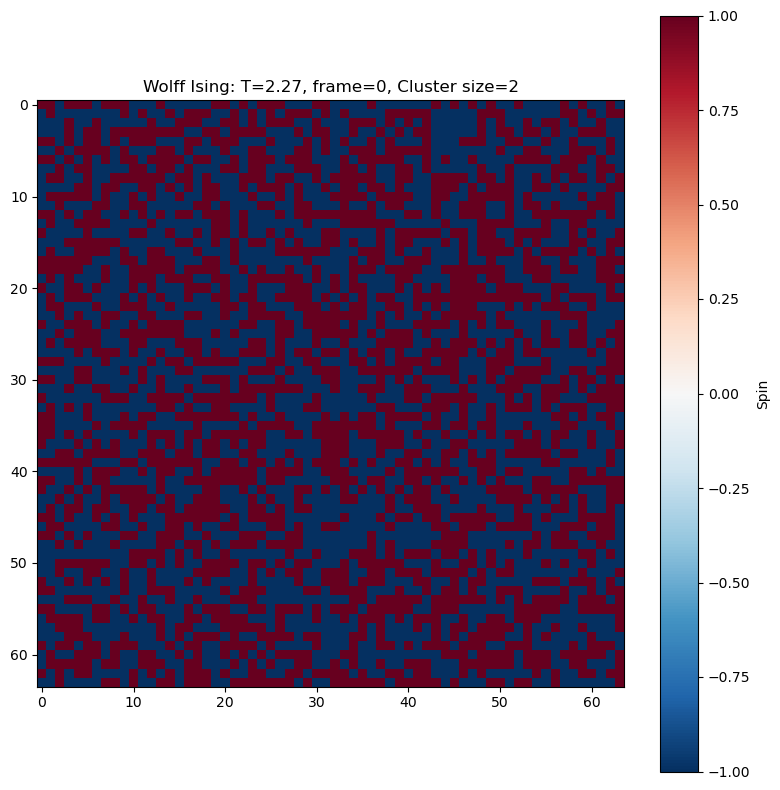

In [40]:
# Animation of Wolff algorithm
def animate_wolff(L=64, J=1.0, T=1.5, frames=200):
    """Live Wolff Ising evolution."""
    beta = 1/T
    lattice = 2 * np.random.randint(2, size=(L, L)) - 1
    
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(lattice, cmap='RdBu_r', vmin=-1, vmax=1, animated=True)
    ax.set_title(f'Wolff 2D Ising: T={T:.2f}, J={J}')
    plt.colorbar(im, ax=ax, label='Spin')
    
    def update(frame):
        # One Wolff cluster flip
        i, j = np.random.randint(0, L, 2)  # Random seed
        spin = lattice[i, j]
        cluster = []
        stack = collections.deque([(i, j)])
        visited = np.zeros((L, L), bool)
        
        while stack:
            ci, cj = stack.pop()
            if visited[ci, cj]:
                continue
            visited[ci, cj] = True
            cluster.append((ci, cj))
            
            # 4 neighbors (periodic)
            for di, dj in [(0,1),(0,-1),(1,0),(-1,0)]:
                ni, nj = (ci + di) % L, (cj + dj) % L
                if lattice[ni, nj] == spin and not visited[ni, nj] and np.random.rand() < (1 - np.exp(-2 * beta * J)):
                    stack.append((ni, nj))
        
        # Flip
        for ci, cj in cluster:
            lattice[ci, cj] *= -1
        
        # Update image data
        im.set_array(lattice)
        ax.set_title(f'Wolff Ising: T={T:.2f}, frame={frame}, Cluster size={len(cluster)}')
        return [im]
    
    ani = FuncAnimation(fig, update, frames=frames, interval=50, blit=True, repeat=True)
    plt.tight_layout()
    return ani

# Run animation
ani = animate_wolff(L=64, T=2.27)  # Near T_c for big clusters
plt.show()


In [41]:
## change these parameters for a smaller (faster) simulation 
nt       = 1000         #  number of temperature points
N        = 80         #  size of the lattice, N x N
eqSteps  = 1024       #  number of MC sweeps for equilibration
mcSteps  = 1024       #  number of MC sweeps for calculation
n_sweeps = 1000

T        = np.linspace(1.53, 3.28, nt)
J        = 1
L        = 32
# E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
# n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values


# Example: Run at T near Tc, compute observables
T_c = 2.269
Tc_guess = 2.28
# L = 64

In [43]:

mag, final_lat = classical_2D_ising(L = L, J = J, T = T_c, n_sweeps = n_sweeps)
print("Mean |M|:", np.mean(np.abs(mag)))
# plt.imshow(final_lat, cmap='RdBu'); plt.show()

Mean |M|: 0.6448279272151899


NameError: name 'X' is not defined

In [44]:
import numpy as np
import collections
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def classical_2D_ising(L, J, T, n_sweeps=10**4, burn=0.2, thin=10):
    """
    Wolff cluster algorithm for 2D classical Ising model.
    Returns time series of magnetization and final lattice.
    """
    beta = 1.0 / T
    mag_history = []
    lattice = 2 * np.random.randint(2, size=(L, L)) - 1
    
    for sweep in range(n_sweeps):
        # Wolff cluster flip
        spin = lattice[0, 0]  # arbitrary seed
        cluster = []
        stack = collections.deque([(0, 0)])
        
        while stack:
            i, j = stack.pop()
            if (i, j) in cluster:
                continue
            cluster.append((i, j))
            
            # 4 nearest neighbors with periodic BC
            neighbors = [((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L)]
            for ni, nj in neighbors:
                if lattice[ni, nj] == spin and np.random.rand() < 1 - np.exp(-2 * beta * J):
                    stack.append((ni, nj))
        
        # Flip all spins in cluster
        for i, j in cluster:
            lattice[i, j] *= -1
        
        # Record thinned, post-burnin magnetization
        if sweep > burn * n_sweeps and sweep % thin == 0:
            M = np.mean(lattice)
            mag_history.append(M)
    
    return np.array(mag_history), lattice

# Simulation parameters (adjusted for reasonable runtime)
J = 1.0
L = 32
T_c = 2.269  # known exact Tc / J for infinite 2D Ising [web:18]
nt = 15  # number of T points above Tc
n_sweeps = 5000
burn_frac = 0.3
thin = 10

# Temperature range T > Tc for exponential fit |M| ~ exp(-tau / xi) ~ exp(-const * tau^gamma), tau = T-Tc
tau_range = np.linspace(0.05, 0.3, nt)  # reduced tau = T - Tc
T_above = T_c + tau_range

print("Running simulations for finite-size magnetization above Tc...")
m_avgs = []
for idx, T in enumerate(T_above):
    print(f"T={T:.3f} ({idx+1}/{nt})")
    mag_hist, _ = classical_2D_ising(L, J, T, n_sweeps=n_sweeps, burn=burn_frac, thin=thin)
    m_abs = np.abs(mag_hist)
    m_avg = np.mean(m_abs)  # < |M| > for T > Tc [web:9]
    m_avgs.append(m_avg)

m_avgs = np.array(m_avgs)

# Fit exponential: log|M| = log A - B * tau^gamma, tau = T - Tc [web:2][web:4][web:8]
def exp_decay(tau, logA, B, gamma):
    return logA - B * tau**gamma

# Prepare data
log_m = np.log(m_avgs)
popt, pcov = curve_fit(exp_decay, tau_range, log_m, p0=[np.log(np.mean(m_avgs)), 10, 1.75])

logA, B, gamma_fit = popt
gamma_err = np.sqrt(pcov[2,2])

print("\nFitted parameters:")
print(f"log A = {logA:.4f}")
print(f"B = {B:.4f}")
print(f"gamma = {gamma_fit:.4f} ± {gamma_err:.4f}")

# For comparison, exact gamma=1.75 for susceptibility chi ~ |T-Tc|^(-gamma), but here finite-size |M| decay [web:18]
print(f"\nExact theoretical gamma (susceptibility) = 1.75 [web:18]")


Running simulations for finite-size magnetization above Tc...
T=2.319 (1/15)
T=2.337 (2/15)
T=2.355 (3/15)
T=2.373 (4/15)
T=2.390 (5/15)
T=2.408 (6/15)
T=2.426 (7/15)
T=2.444 (8/15)
T=2.462 (9/15)
T=2.480 (10/15)
T=2.498 (11/15)
T=2.515 (12/15)
T=2.533 (13/15)
T=2.551 (14/15)
T=2.569 (15/15)

Fitted parameters:
log A = 0.7479
B = 3.8572
gamma = 0.3412 ± 0.1861

Exact theoretical gamma (susceptibility) = 1.75 [web:18]
